In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
SEASON = 12
df = pd.read_csv(f'../data/{SEASON}/results/signal.csv', index_col=0)
df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{SEASON}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy')
df_triggers = pd.read_csv(f'../data/{SEASON}/results/triggers.csv', index_col=0)
df = df.join(df_lum).join(df_triggers[['eff_trig', 'eff_trig_err']])
df['n0_mc'] = 20000

In [4]:
df.head()

,n_sig_exp,n_bkg_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,k_exp,n_sig_exp_err,n_bkg_exp_err,...,sL_mc_err,sR_mc_err,aL_mc_err,aR_mc_err,emeas,lum,lum_err,eff_trig,eff_trig_err,n0_mc
640.0,110.179383,21.821007,1.224819,2.815781,1.992523,0.078871,0.152906,1.726345e-09,8.328471,4.987304,...,0.148076,0.175607,0.003170,0.006829,638.531128,720.300,1.61362,0.937659,0.034137,20000
680.0,93.836731,34.163301,0.940107,2.558189,2.972100,0.105672,0.127472,1.865809e-03,9.162935,7.349247,...,0.155850,0.232489,0.003194,0.008682,678.274841,843.291,1.85485,0.913611,0.040317,20000
720.0,58.979413,32.020617,0.327526,2.403623,2.160278,0.074885,0.123598,1.496575e-09,9.396211,8.647974,...,0.142963,0.161879,0.003326,0.005984,717.460205,915.812,2.04444,0.913779,0.046241,20000
760.0,96.764192,64.233000,-0.156750,2.710368,3.116148,0.078412,0.125290,3.750600e-10,8.654418,7.545921,...,0.088809,0.115463,0.002275,0.004426,757.306396,835.297,2.06166,0.958714,0.022999,20000
800.0,173.270563,5.729480,0.932010,2.479870,2.595294,0.088224,0.115597,1.110223e-14,9.848327,3.621353,...,0.079745,0.096534,0.001969,0.003621,797.500000,824.537,2.15717,0.982629,0.012067,20000


In [4]:
df['eff_reg'], df['eff_reg_err'] = df['n_sig_mc']/df['n0_mc'], df['n_sig_mc_err']/df['n0_mc']

In [5]:
df['cs_vis'] = df['n_sig_exp']/(df['eff_reg']*df['eff_trig']*df['lum'])

In [6]:
df_koz = pd.read_csv('images/kozyrev.txt')
df_koz['emeas'] = df_koz['E']/2
df_koz['cs_vis'] = df_koz['cs']*df_koz['rad']

In [7]:
df_vis = pd.concat([df_koz[['emeas', 'cs_vis']], df[['emeas', 'cs_vis']]], ignore_index=True).sort_values(by='emeas')
df_vis['rad'] = 1
df_vis['cs_born'] = df_vis['cs_vis']/df_vis['rad']

In [8]:
df_vis.head()

,emeas,cs_vis,rad,cs_born
0,502.0330,4.9464,1,4.9464
1,505.2330,30.7768,1,30.7768
2,506.4775,69.6528,1,69.6528
3,507.5340,155.8663,1,155.8663
4,508.0525,260.0943,1,260.0943


In [9]:
df_approx = pd.read_csv('../data/cross_sections_kskl.txt', sep=' ', index_col=0, names=['E', 'cs_born'])
df_approx['emeas'] = df_approx['E']/2
df_approx['rad'] = 1

In [10]:
from scipy.interpolate import make_interp_spline

In [11]:
df_approx

,E,cs_born,emeas,rad
2,995.0,0.000000,497.5,1
3,996.0,0.067593,498.0,1
4,997.0,0.292279,498.5,1
5,998.0,0.642567,499.0,1
6,999.0,1.128050,499.5,1
...,...,...,...,...
545,2092.0,0.368000,1046.0,1
546,2094.0,0.381000,1047.0,1
547,2096.0,0.394000,1048.0,1
548,2098.0,0.409000,1049.0,1


In [12]:
from pylib.radcors import RadCor

1	

/spoolA/petrov/refac20/notebooks/pylib/radcors.py:66: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  0., Xmax, points=[0, 1], limit=50000, epsrel=0.0001)


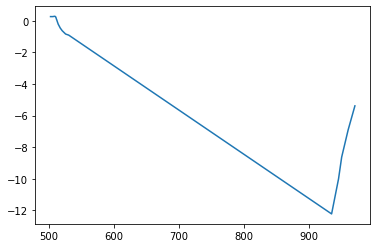

In [57]:
n_iter = 1
for _ in range(n_iter):
    print(_+1, end='\t')
    spl = make_interp_spline(df_approx.emeas, df_approx.cs_born, k=1)
    e_interp = np.linspace(495, 1000, 3000) 
    cs_interp = spl(e_interp)
    cs_interp = np.where(e_interp<497.6, 0, cs_interp)
    cs_interp = np.where(cs_interp<0, 0, cs_interp)

    r = RadCor(e_interp, cs_interp)

    temp_rads = df_vis.rad.copy().astype('float')
    for i, j in df_vis.iterrows():
        temp_rads[i] = r.F_Radcor(j['emeas'])[0]
    if (_==(n_iter-1)):
        plt.plot(df_vis['emeas'], df_vis['rad']-temp_rads)
    
    df_vis['rad'] = temp_rads
    df_vis['cs_born'] = df_vis['cs_vis']/df_vis['rad']

In [58]:
df_vis.tail(5)

,emeas,cs_vis,rad,cs_born
25,934.748108,0.443281,13.225681,0.033517
26,945.436157,0.328599,11.006297,0.029856
27,950.266357,0.499530,9.627165,0.051888
28,960.250549,0.381036,7.900114,0.048232
29,970.637634,0.300854,6.381915,0.047142


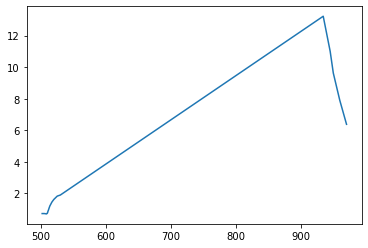

In [59]:
plt.plot(df_vis.emeas, df_vis.rad)

In [60]:
df_n = df.merge(df_vis[['emeas', 'rad']], on='emeas')

In [61]:
df_n['cs_born'] = df_n['cs_vis']/df_n['rad']

In [62]:
df_n.tail()

,n_sig_exp,n_bkg_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,k_exp,n_sig_exp_err,n_bkg_exp_err,...,lum,lum_err,eff_trig,eff_trig_err,n0_mc,eff_reg,eff_reg_err,cs_vis,rad,cs_born
0,91.352114,179.647935,-0.528247,1.781879,1.323840,0.104757,0.252080,0.007588,18.754637,19.982518,...,9285.61,8.37158,0.990931,0.003736,20000,0.022397,0.000764,0.443281,13.225681,0.033517
1,79.874775,85.125234,0.733879,2.275196,2.920783,0.080863,0.187479,0.009647,10.501887,10.625610,...,8912.33,8.29880,0.990097,0.004525,20000,0.027547,0.000857,0.328599,11.006297,0.029856
2,133.352210,138.647813,1.365318,3.308728,2.727496,0.075685,0.180297,0.010680,12.993237,13.094701,...,9675.75,8.69699,0.994219,0.002623,20000,0.027751,0.000848,0.499530,9.627165,0.051888
3,133.058235,212.943228,0.063086,2.980204,2.864606,0.069697,0.153211,0.004876,26.182148,26.926367,...,9904.05,8.88435,0.993366,0.002547,20000,0.035494,0.000942,0.381036,7.900114,0.048232
4,101.949186,192.050907,1.024389,2.095426,2.091710,0.088258,0.158477,0.034136,11.122418,12.989490,...,8871.48,8.49301,0.996023,0.002012,20000,0.038350,0.000987,0.300854,6.381915,0.047142


In [64]:
# df_n.to_csv(f'images/res{SEASON}_new.csv')

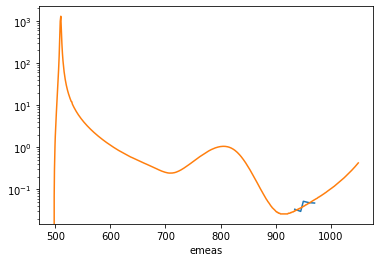

In [65]:
df_n.set_index('emeas').cs_born.plot()
plt.plot(df_approx.emeas, df_approx.cs_born)
plt.yscale('log')

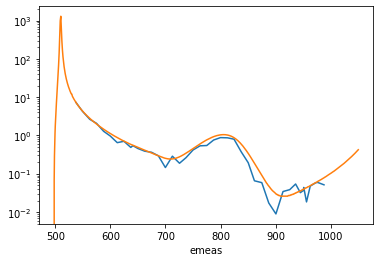

In [64]:
df_n.set_index('emeas').cs_born.plot()
plt.plot(df_approx.emeas, df_approx.cs_born)
plt.yscale('log')

Сечение

In [66]:
dfs = [pd.read_csv('images/res11_new.csv', index_col=0),
       pd.read_csv('images/res12_new.csv', index_col=0),
       pd.read_csv('images/res19_new.csv', index_col=0),
       pd.read_csv('images/res20_new.csv', index_col=0),
      ]

In [67]:
for df in dfs:
    if 'n_sig_exp' not in df.columns:
        df['n_sig'] = df['n_exp']*df['f_exp']
        df['n_sig_err'] = df['n_sig']*np.sqrt( (df['n_exp_err']/df['n_exp'])**2 + (df['f_exp_err']/df['f_exp'])**2 )
    else:
        df['n_sig'] = df['n_sig_exp']
        df['n_sig_err'] = df['n_sig_exp_err']
    df['cs_born_err'] = df['cs_born']*np.sqrt( (df['n_sig_err']/df['n_sig'])**2 + (df['eff_reg_err']/df['eff_reg'])**2 +\
                                             (df['eff_trig_err']/df['eff_trig'])**2)

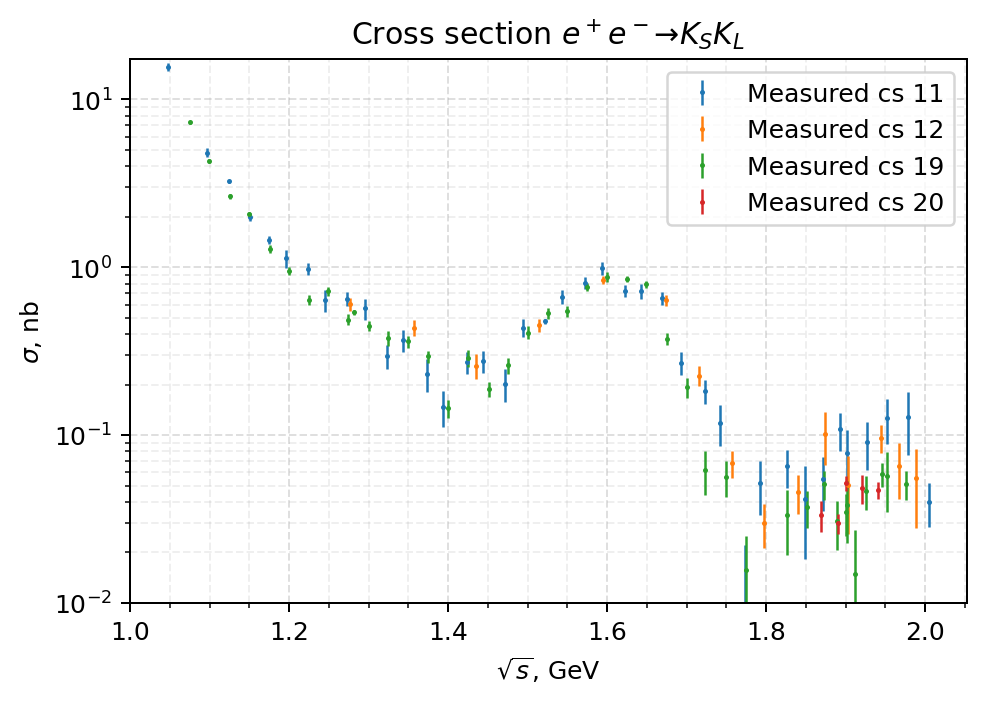

In [68]:
plt.figure(dpi=180)
for df, e in zip(dfs, ['11', '12', '19', '20']):
    plt.errorbar(df.emeas*2e-3, df.cs_born, yerr=df.cs_born_err, fmt='.', label=f'Measured cs {e}', alpha=1, markersize=2, lw=1)
# plt.plot(df_approx.emeas*2e-3, df_approx.cs_born, label='Cross section in MC')
# plt.errorbar(df_koz.E, df_koz.cs, yerr=df_koz.cs_err, fmt='.')
# plt.xlim(520*2, 1200)
plt.grid(ls='--', alpha=0.4)
plt.grid(which='minor', ls='--', alpha=0.2)
plt.minorticks_on()
plt.legend()
plt.ylim(1e-2, None)
plt.yscale('log')
plt.title('Cross section $e^+ e^- \\to K_S K_L$')
plt.ylabel('$\sigma$, nb')
plt.xlabel('$\sqrt{s}$, GeV');
# plt.savefig('images/cs_kskl1.png', dpi=120)

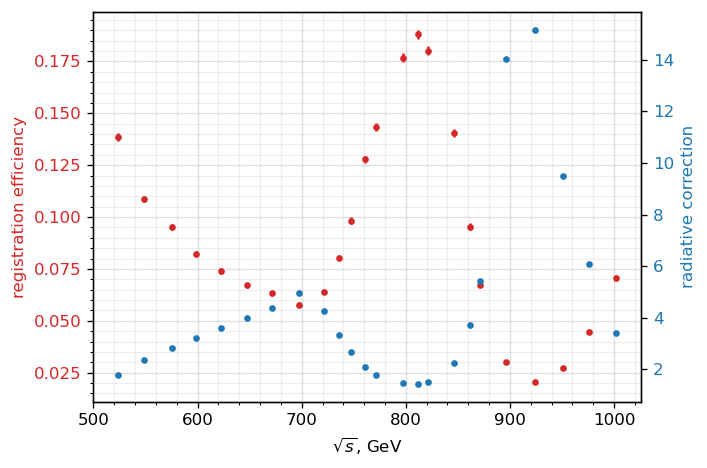

In [27]:
fig, ax1 = plt.subplots(dpi=120)

color = 'tab:red'
ax1.set_xlabel('$\sqrt{s}$, GeV')
ax1.set_ylabel('registration efficiency', color=color)
ax1.errorbar(df.emeas, df.eff_reg, yerr=df.eff_reg_err, fmt='.', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('radiative correction', color=color)  # we already handled the x-label with ax1
ax2.scatter(df.emeas, df.rad, marker='.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid(alpha=0.4)
ax1.minorticks_on()
ax1.grid(which='minor', alpha=0.2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('images/rad_reg_eff.png', dpi=120)